In [1]:
# Import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json, codecs, os, csv
from time import time
import re
from lxml.etree import tostring
from selenium import webdriver
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from underthesea import sent_tokenize
from underthesea import word_tokenize
from underthesea import ner
from sklearn.model_selection import train_test_split

# 1. Tiền xử lí dữ liệu

## 1. 1 Chuẩn hóa dữ liệu 

In [2]:
# Hàm Chuẩn hóa chuỗi thành chữ thường 
def lower_sentence(sentence):
    s = sentence.lower()
    return s

# Hàm Loại bỏ dấu câu và các ký tự đặc biệt
def punctuation_and_special_characters(sentence):
    s = re.sub('\W+',' ', sentence)
    return s

# Trường hợp người dùng láy âm tiết
def sound_syllable(sentence):
    s = re.sub(r'(\D)\1+', r'\1', sentence)
    return s

In [3]:
correct_mapping = {
    "ship": "vận chuyển",
    "shop": "cửa hàng",
    "m": "mình",
    "mik": "mình",
    "ko": "không",
    "k": " không ",
    "kh": "không",
    "khong": "không",
    "kg": "không",
    "khg": "không",
    "tl": "trả lời",
    "r": "rồi",
    "fb": "mạng xã hội facebook",
    "face": "mạng xã hội",
    "thanks": "cảm ơn",
    "thank": "cảm ơn",
    "tks": "cảm ơn",
    "tk": "cảm ơn",
    "ok": "tốt",
    "dc": "được",
    "vs": "với",
    "đt": "điện thoại",
    "thjk": "thích",
    "thik": "thích",
    "qá": "quá",
    "trể": "trễ",
    "bgjo": "bao giờ",
    "mn": "mọi người",
    "seal": "niêm phong"
}

def word_map(sentence):
    tokens = sentence.split()
    i = 0
    
    for token in tokens:
        if token.lower() in correct_mapping:
            word = correct_mapping[token.lower()]
            tokens[i] = word
            
        i += 1
        
    return " ".join(tokens)

In [4]:
def PreProcessing(dataFrame):
    df_copy = df_0.copy()

    df_copy['comment'] = df_copy['comment'].astype(str)
    df_copy["comment_clear"] = df_copy.apply(lambda x : lower_sentence(x['comment']),axis = 1 )
    df_copy["comment_clear"] = df_copy.apply(lambda x : punctuation_and_special_characters(x['comment_clear']),axis = 1 )
    df_copy["comment_clear"] = df_copy.apply(lambda x : sound_syllable(x['comment_clear']),axis =1)
    df_copy["comment_clear"] = df_copy.apply(lambda x : word_map(x['comment_clear']),axis =1)
    
    df_copy.dropna(inplace = True)
    df_copy['rating'].dropna()
    
    df_copy.drop(df_copy[(df_copy['rating'] == 'g')|(df_copy['rating'] == ',')].index, inplace=True)
    df_copy['rating'] = df_copy['rating'].astype(int)
    
    df_copy['total_comment'] = df_copy.groupby('comment')['rating'].transform('count')
    df_copy['total_rating'] = df_copy.groupby('comment')['rating'].transform('sum')
    df_copy['average_rating'] = df_copy['total_rating']/df_copy['total_comment']
    
    
    df1 = df_copy.copy()
    df1 = df1.drop(['STT','comment', 'rating', 'total_comment', 'total_rating'], axis = 1)
    
    row_indexes = df1[df1['average_rating'] >= 4.0].index
    df1.loc[row_indexes,'label'] = 1
    
    row_indexes = df1[df1['average_rating'] < 4.0].index
    df1.loc[row_indexes,'label'] = 0
    
    df1['label'] = df1['label'].astype(int)

    return df_copy, df1

In [5]:
df_0 = pd.read_csv('Data.csv')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df1, df = PreProcessing(df_0)

In [7]:
df1[df1.comment_clear.isna()==True]

,STT,comment,rating,comment_clear,total_comment,total_rating,average_rating


In [8]:
df1[df1.comment_clear =='tốt']

,STT,comment,rating,comment_clear,total_comment,total_rating,average_rating
15,16,Tốt,5,tốt,14106,66909,4.743301
25,26,Tốt,5,tốt,14106,66909,4.743301
38,39,Tốt,5,tốt,14106,66909,4.743301
79,80,Tốt,5,tốt,14106,66909,4.743301
107,108,ok,4,tốt,1427,6602,4.626489
...,...,...,...,...,...,...,...
544773,544774,Tốt,5,tốt,14106,66909,4.743301
544783,544784,Tốt,5,tốt,14106,66909,4.743301
544806,544807,tốt,5,tốt,3334,15920,4.775045
544807,544808,Tốt,5,tốt,14106,66909,4.743301


In [9]:
pos = df[df['label'] == 1].count().values[0]
neg = df[df['label'] == 0].count().values[0]

df2 = pd.DataFrame(['Postitive', 'Negative'])
df2['total'] = [pos, neg]

df2

,0,total
0,Postitive,417598
1,Negative,121997


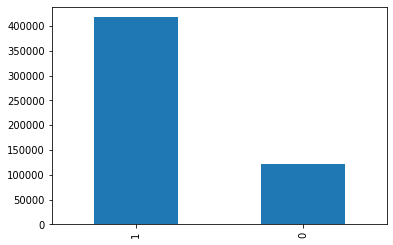

In [10]:
# Vẽ đồ thị của data, trục x là các loại ý kiến, trục y là số lượng của từng loại ý kiến
df['label'].value_counts().plot(kind='bar')

In [11]:
# Chia dữ liệu ra làm 2 tập là tập huấn luyện và tập kiểm tra theo tỉ lệ 80%:20%
train_X, test_X, train_y, test_y = train_test_split(df['comment_clear'], df['label'], 
                                                    test_size=0.2, random_state=0, stratify=df['label'])

train_X.head()

503318            hài lòng ủng hộ cửa hàng
9607                              hài lòng
263663    hài lòng với sản phẩm và dịch vụ
314361                         bình thường
289688               cửa hàng giao sai mầu
Name: comment_clear, dtype: object

In [12]:
train_y.head()

503318    1
9607      1
263663    1
314361    0
289688    0
Name: label, dtype: int32

In [13]:
df

,comment_clear,average_rating,label
0,bóc niêm phong hộ à,1.000000,0
1,hài lòng,4.202278,1
2,máy ổn trong tầm giá,4.764706,1
3,sản phẩm đúng theo mô tả giao hàng nhanh,5.000000,1
4,hẩu hết đúng mô tả tuy nhiên có chi tiết nhỏ c...,5.000000,1
...,...,...,...
544985,hàng tốt,4.880026,1
544986,hài lòng,4.202278,1
544987,cực kì hài lòng,4.999647,1
544988,cực kì hài lòng,4.999647,1


In [14]:
df.to_csv("data_clean.csv", sep = ',')